# Specific User Journey Analysis

This notebook analyzes the purchase journey for a specific user ID: `e2eb1291-5fec-45e6-bded-3018f0d67d66`. It leverages the same methods and data processing as the main purchase journey analysis notebook.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Load the dataset
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

# Define the user ID we're interested in
TARGET_USER_ID = 'e2eb1291-5fec-45e6-bded-3018f0d67d66'

In [2]:
# Clean the data and filter relevant entries - same as in purchase_journey_analysis
# Remove entries without user_id or with placeholder user_ids
df_filtered = df[(df['user_id'] != 'none') & (df['user_id'] != 'less-website')].copy()

# Convert timestamp strings to datetime objects
df_filtered['timestamp'] = pd.to_datetime(df_filtered['created_at'], format='ISO8601')

# Define purchase event indicators
purchase_event_types = ['enforce_wait_modal_shown']

# Function to check if an event type indicates a purchase
def is_purchase_event(event_type):
    # Check for exact matches
    if event_type in purchase_event_types:
        return True
    
    # Check for partial matches in case the naming convention varies
    for purchase_type in purchase_event_types:
        if purchase_type.lower() in event_type.lower():
            return True
    
    return False

# Add a column to identify purchase events
df_filtered['is_purchase'] = df_filtered['type'].apply(is_purchase_event)

# Define the other event types we're interested in
df_filtered['is_add_to_cart'] = df_filtered['type'] == 'add-to-cart'
df_filtered['is_checkout'] = df_filtered['type'] == 'checkout'

In [3]:
# Process sessions - same as in purchase_journey_analysis
session_groups = df_filtered.groupby('session_id')

# Extract session start times, end times, duration, and whether each session contains a purchase
session_data = []
for session_id, session_df in session_groups:
    # Skip sessions with invalid or placeholder IDs
    if session_id == 'none' or pd.isna(session_id):
        continue
        
    # Sort session events by timestamp
    session_df = session_df.sort_values('timestamp')
    
    # Get user_id (assuming it's consistent within a session)
    user_id = session_df['user_id'].iloc[0] if not session_df.empty else None
    
    # Get session start and end times
    start_time = session_df['timestamp'].min()
    end_time = session_df['timestamp'].max()
    
    # Calculate session duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    
    # Check for each event type - ensuring uniqueness per session by using .any()
    has_add_to_cart = session_df['is_add_to_cart'].any()
    has_checkout = session_df['is_checkout'].any()
    has_purchase = session_df['is_purchase'].any()
    
    # Find timestamps for FIRST occurrence of each event type
    add_to_cart_time = session_df[session_df['is_add_to_cart']]['timestamp'].min() if has_add_to_cart else None
    checkout_time = session_df[session_df['is_checkout']]['timestamp'].min() if has_checkout else None
    purchase_time = session_df[session_df['is_purchase']]['timestamp'].min() if has_purchase else None
    
    # Determine event sequence order based on first occurrences
    event_order = []
    if has_add_to_cart:
        event_order.append(('add_to_cart', add_to_cart_time))
    if has_checkout:
        event_order.append(('checkout', checkout_time))
    if has_purchase:
        event_order.append(('purchase', purchase_time))
    
    # Sort events by timestamp
    event_order.sort(key=lambda x: x[1])
    
    # Extract the ordered sequence of event types
    event_sequence = [event[0] for event in event_order]
    event_sequence_str = ' → '.join(event_sequence) if event_sequence else 'no_events'
    
    # Collect relevant session details
    session_data.append({
        'session_id': session_id,
        'user_id': user_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration_minutes': duration_minutes,
        'has_add_to_cart': has_add_to_cart,
        'has_checkout': has_checkout,
        'has_purchase': has_purchase,
        'event_sequence': event_sequence_str,
        'event_count': len(session_df),
        'domain': session_df['domain'].iloc[0] if 'domain' in session_df.columns and not session_df.empty else 'unknown'
    })

# Create DataFrame from collected session data
sessions_df = pd.DataFrame(session_data)

# Add flow categorization
def categorize_flow(row):
    # Complete flow
    if row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Complete Flow'
    
    # Add to cart then checkout
    elif row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart then Checkout'
    
    # Checkout then purchase
    elif not row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Checkout then Purchase'
    
    # Just add to cart
    elif row['has_add_to_cart'] and not row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart'
    
    # Just checkout
    elif not row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Checkout'
    
    # Just purchase (unusual but possible)
    elif not row['has_add_to_cart'] and not row['has_checkout'] and row['has_purchase']:
        return 'Direct Purchase'
    
    # Just looking
    else:
        return 'Just Looking'

# Apply the flow categorization
sessions_df['flow_category'] = sessions_df.apply(categorize_flow, axis=1)

# Add the simpler categorization as well
def categorize_session(row):
    if not row['has_purchase']:
        return 'Just Looking'
    elif row['duration_minutes'] >= 20:
        return 'Looking Then Purchasing'
    else:
        return 'Quick Purchase'

sessions_df['category'] = sessions_df.apply(categorize_session, axis=1)

# Check if our target user exists in the data
if TARGET_USER_ID in sessions_df['user_id'].values:
    print(f"User {TARGET_USER_ID} found in the dataset!")
    
    # Get basic statistics for this user
    user_sessions = sessions_df[sessions_df['user_id'] == TARGET_USER_ID]
    print(f"Total sessions for this user: {len(user_sessions)}")
    print(f"Sessions with purchases: {user_sessions['has_purchase'].sum()}")
    
    # Display a summary of the user's sessions
    print("\nSummary of user's sessions:")
    print(user_sessions[['session_id', 'start_time', 'duration_minutes', 'flow_category', 'has_purchase']].sort_values('start_time'))
else:
    print(f"User {TARGET_USER_ID} not found in the dataset.")

User e2eb1291-5fec-45e6-bded-3018f0d67d66 found in the dataset!
Total sessions for this user: 5
Sessions with purchases: 2

Summary of user's sessions:
                               session_id                       start_time  \
125  b18a1f97-4630-4a17-90a4-f009b7bbed96 2025-04-30 21:06:02.587000+00:00   
173  fb605d76-2994-43de-b833-b1aa234dfefa 2025-05-05 02:20:40.020000+00:00   
151  e404b458-5433-4acc-800b-70c85347e4c8 2025-05-08 11:11:18.088000+00:00   
42   362bb0d3-4848-40cd-bdc1-60360897d06b 2025-05-08 23:13:22.038000+00:00   
94   82e7ad72-c699-44b1-9e52-6a246fbf03e4 2025-05-11 18:22:13.224000+00:00   

     duration_minutes           flow_category  has_purchase  
125         34.885050            Just Looking         False  
173          0.000000            Just Looking         False  
151         10.741733  Checkout then Purchase          True  
42          29.254617           Complete Flow          True  
94           0.000000            Just Looking         False  


In [4]:
# For our target user, analyze the purchase journey
if TARGET_USER_ID in sessions_df['user_id'].values:
    user_sessions = sessions_df[sessions_df['user_id'] == TARGET_USER_ID].sort_values('start_time')
    
    # Find the first purchase session (if any)
    purchase_sessions = user_sessions[user_sessions['has_purchase']]
    
    if not purchase_sessions.empty:
        first_purchase_session = purchase_sessions.iloc[0]
        purchase_time = first_purchase_session['start_time']
        
        print(f"First purchase session found on: {purchase_time}")
        print(f"Purchase flow category: {first_purchase_session['flow_category']}")
        
        # Get all sessions before the first purchase
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < purchase_time]
        
        print(f"\nNumber of sessions before first purchase: {len(pre_purchase_sessions)}")
        if len(pre_purchase_sessions) > 0:
            days_to_purchase = (purchase_time - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
            print(f"Days from first session to first purchase: {days_to_purchase:.2f}")
            
            # Count pre-purchase session types
            pre_purchase_just_looking = sum(1 for _, row in pre_purchase_sessions.iterrows() if row['flow_category'] == 'Just Looking')
            pre_purchase_add_to_cart = sum(1 for _, row in pre_purchase_sessions.iterrows() if 'Add-to-Cart' in row['flow_category'])
            pre_purchase_checkout = sum(1 for _, row in pre_purchase_sessions.iterrows() if 'Checkout' in row['flow_category'])
            
            print(f"Just Looking sessions: {pre_purchase_just_looking}")
            print(f"Add to Cart sessions: {pre_purchase_add_to_cart}")
            print(f"Checkout sessions: {pre_purchase_checkout}")
            
            # Create a comprehensive journey object for visualization
            journey_data = {
                'user_id': TARGET_USER_ID,
                'total_sessions_before_purchase': len(pre_purchase_sessions),
                'days_to_first_purchase': days_to_purchase,
                'first_purchase_session_id': first_purchase_session['session_id'],
                'first_purchase_category': first_purchase_session['category'],
                'first_purchase_flow': first_purchase_session['flow_category'],
                'pre_purchase_session_categories': pre_purchase_sessions['category'].tolist() if not pre_purchase_sessions.empty else [],
                'pre_purchase_flow_categories': pre_purchase_sessions['flow_category'].tolist() if not pre_purchase_sessions.empty else [],
                'pre_purchase_just_looking_count': pre_purchase_just_looking,
                'pre_purchase_add_to_cart_count': pre_purchase_add_to_cart,
                'pre_purchase_checkout_count': pre_purchase_checkout
            }
        else:
            print("User purchased in their first session (no pre-purchase sessions)")
            
            # Create a minimal journey object for first-time purchasers
            journey_data = {
                'user_id': TARGET_USER_ID,
                'total_sessions_before_purchase': 0,
                'days_to_first_purchase': 0,
                'first_purchase_session_id': first_purchase_session['session_id'],
                'first_purchase_category': first_purchase_session['category'],
                'first_purchase_flow': first_purchase_session['flow_category'],
                'pre_purchase_session_categories': [],
                'pre_purchase_flow_categories': [],
                'pre_purchase_just_looking_count': 0,
                'pre_purchase_add_to_cart_count': 0,
                'pre_purchase_checkout_count': 0
            }
    else:
        print("No purchase sessions found for this user.")
else:
    print(f"User {TARGET_USER_ID} not found in the dataset.")

First purchase session found on: 2025-05-08 11:11:18.088000+00:00
Purchase flow category: Checkout then Purchase

Number of sessions before first purchase: 2
Days from first session to first purchase: 7.59
Just Looking sessions: 2
Add to Cart sessions: 0
Checkout sessions: 0


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_23821/3902201521.py:97: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


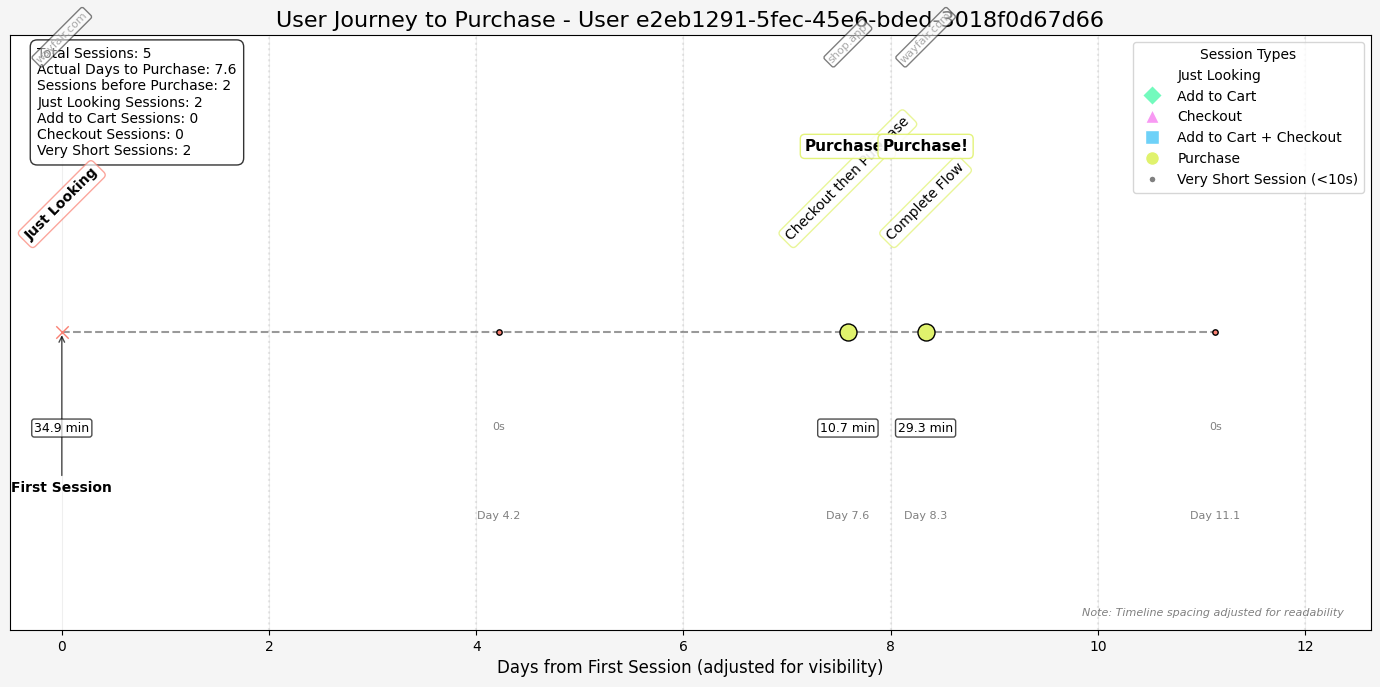

Journey Pattern for User e2eb1291-5fec-45e6-bded-3018f0d67d66:
Just Looking → [<10s] Just Looking → Checkout then Purchase (Purchase!) → Complete Flow (Purchase!) → [<10s] Just Looking


In [5]:
# Visualize the user's journey
if TARGET_USER_ID in sessions_df['user_id'].values:
    user_sessions = sessions_df[sessions_df['user_id'] == TARGET_USER_ID].sort_values('start_time')
    
    # Find purchase sessions
    purchase_sessions = user_sessions[user_sessions['has_purchase']]
    
    if not purchase_sessions.empty:
        # Prepare data for visualization
        timeline_data = []
        for _, session in user_sessions.iterrows():
            # No longer skipping very short sessions - we'll visualize them with dots on the timeline
            
            # Calculate time from first session
            time_from_first = (session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
            
            # Flag for very short sessions (less than 10 seconds)
            is_very_short = session['duration_minutes'] < (10 / 60)
            
            # Determine session type color and marker
            if session['has_purchase']:
                color = colors[4]  # Purchase event
                marker = 'o'
                size = 150
                zorder = 10
            elif 'Add-to-Cart' in session['flow_category'] and 'Checkout' in session['flow_category']:
                color = colors[3]  # Add to cart + checkout
                marker = 's'
                size = 120
                zorder = 8
            elif 'Add-to-Cart' in session['flow_category']:
                color = colors[2]  # Add to cart
                marker = 'D'
                size = 100
                zorder = 6
            elif 'Checkout' in session['flow_category']:
                color = colors[1]  # Checkout
                marker = '^'
                size = 100
                zorder = 7
            else:
                color = colors[0]  # Just looking
                marker = 'x'
                size = 80
                zorder = 5
                
            timeline_data.append({
                'session_id': session['session_id'],
                'time_days': time_from_first,
                'duration_minutes': session['duration_minutes'],
                'flow_category': session['flow_category'],
                'has_purchase': session['has_purchase'],
                'color': color,
                'marker': marker,
                'size': size,
                'zorder': zorder,
                'is_very_short': is_very_short,
                'domain': session['domain'] if 'domain' in session else 'unknown'
            })
        
        # Adjust x-coordinates for better spacing when events are too close
        # Sort by time
        timeline_data.sort(key=lambda x: x['time_days'])
        
        # Define minimum gap (in days) that we want between events
        min_gap = 0.75  # Minimum gap for readability
        
        # Adjust positions
        for j in range(1, len(timeline_data)):
            actual_gap = timeline_data[j]['time_days'] - timeline_data[j-1]['time_days']
            
            # If events are too close together
            if 0 < actual_gap < min_gap:
                # Shift current and all following events to maintain minimum gap
                shift = min_gap - actual_gap
                for k in range(j, len(timeline_data)):
                    timeline_data[k]['time_days'] += shift
        
        # Create the timeline visualization
        plt.figure(figsize=(14, 7), facecolor=facecolor)
        
        # Plot each session as a point
        for session in timeline_data:
            # Use different visualization for very short sessions
            if session['is_very_short']:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=60,  # Smaller size for very short sessions
                    marker='.',  # Dot marker for very short sessions
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            else:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=session['size'],
                    marker=session['marker'],
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            
            # Add flow category label above point with more vertical space
            # Only add text labels for sessions that aren't very short to avoid clutter
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.65,  # Increased vertical position
                    session['flow_category'],
                    rotation=45,
                    ha='center',
                    va='bottom',
                    fontsize=10,  # Slightly larger font
                    fontweight='bold' if not session['has_purchase'] else 'normal',  # Normal weight for purchase events
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor=session['color'], boxstyle='round,pad=0.3'),
                    zorder=session['zorder']
                )
            
            # For purchase sessions, add a "Purchase!" label at a different position so it doesn't overlap
            if session['has_purchase']:
                plt.text(
                    session['time_days'],
                    0.8,  # Higher position to avoid overlap
                    "Purchase!",
                    rotation=0,  # No rotation for better visibility
                    ha='center',
                    va='bottom',
                    fontsize=11,  # Slightly larger font for emphasis
                    fontweight='bold',
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.9, edgecolor=colors[4], boxstyle='round,pad=0.3'),
                    zorder=session['zorder'] + 1  # Higher zorder to stand out
                )
            
            # Add domain information where available
            if 'domain' in session and session['domain'] != 'unknown':
                domain_text = session['domain']
                # Truncate very long domain names
                if len(domain_text) > 25:
                    domain_text = domain_text[:22] + "..."
                
                # Only add domain text for non-very-short sessions to avoid clutter
                if not session['is_very_short']:
                    plt.text(
                        session['time_days'],
                        0.95,  # Higher position for domain
                        domain_text,
                        rotation=45,
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='darkgray',
                        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2'),
                        zorder=session['zorder'] - 1
                    )
            
            # Add duration label below point (only for non-very-short sessions)
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position for better spacing
                    f"{session['duration_minutes']:.1f} min",
                    ha='center',
                    va='top',
                    fontsize=9,
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
                    zorder=session['zorder']
                )
            # For very short sessions, add a small duration label
            else:
                seconds = session['duration_minutes'] * 60
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position
                    f"{seconds:.0f}s",  # Show seconds instead of minutes
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
            
            # Add time from first session as a more subtle label
            if session['time_days'] > 0.1:  # Skip for first session
                plt.text(
                    session['time_days'],
                    0.2,  # Lower position
                    f"Day {session['time_days']:.1f}",
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
        
        # Connect points with lines - now dotted for better aesthetics
        times = [session['time_days'] for session in timeline_data]
        plt.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1.5)
        
        # Add clear markers for timeline scale
        if max(times) > 3:  # Only add markers if timeline is long enough
            day_markers = list(range(0, int(max(times)) + 2, 2))  # Every 2 days
            for day in day_markers:
                if day > 0:  # Skip day 0
                    plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.5, zorder=0)
        
        # Add annotations for first session only
        if len(timeline_data) > 0:
            plt.annotate('First Session', 
                       (timeline_data[0]['time_days'], 0.5),
                       xytext=(timeline_data[0]['time_days'], 0.25),
                       arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                       ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Set up the plot with improved aesthetics
        plt.title(f'User Journey to Purchase - User {TARGET_USER_ID}', fontsize=16)
        plt.xlabel('Days from First Session (adjusted for visibility)', fontsize=12)
        plt.yticks([])
        plt.grid(True, axis='x', alpha=0.2)
        
        # Add padding to x-axis for better appearance
        plt.xlim(left=-0.5, right=max(times) + 1.5 if times else 1)
        plt.ylim(0, 1)
        
        # Add a legend with improved positioning - now including very short sessions
        legend_elements = [
            plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=10, label='Just Looking'),
            plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=10, label='Add to Cart'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=10, label='Checkout'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label='Add to Cart + Checkout'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=10, label='Purchase'),
            plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=10, label='Very Short Session (<10s)')
        ]
        plt.legend(handles=legend_elements, loc='upper right', title='Session Types')
        
        # Add journey stats
        first_purchase_session = purchase_sessions.iloc[0]
        original_days = (first_purchase_session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
        
        # Count very short sessions
        very_short_count = sum(1 for session in timeline_data if session['is_very_short'])
        
        stats_text = f"Total Sessions: {len(timeline_data)}\n"
        stats_text += f"Actual Days to Purchase: {original_days:.1f}\n"
        
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < first_purchase_session['start_time']]
        stats_text += f"Sessions before Purchase: {len(pre_purchase_sessions)}\n"
        
        pre_purchase_just_looking = sum(1 for _, row in pre_purchase_sessions.iterrows() if row['flow_category'] == 'Just Looking')
        pre_purchase_add_to_cart = sum(1 for _, row in pre_purchase_sessions.iterrows() if 'Add-to-Cart' in row['flow_category'])
        pre_purchase_checkout = sum(1 for _, row in pre_purchase_sessions.iterrows() if 'Checkout' in row['flow_category'])
        
        stats_text += f"Just Looking Sessions: {pre_purchase_just_looking}\n"
        stats_text += f"Add to Cart Sessions: {pre_purchase_add_to_cart}\n"
        stats_text += f"Checkout Sessions: {pre_purchase_checkout}\n"
        stats_text += f"Very Short Sessions: {very_short_count}"
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 va='top', ha='left', fontsize=10)
        
        # Add note about adjusted timeline
        plt.text(0.98, 0.02, "Note: Timeline spacing adjusted for readability", 
                 transform=plt.gca().transAxes,
                 va='bottom', ha='right', fontsize=8, fontstyle='italic', color='gray')
        
        plt.tight_layout()
        plt.show()
        
        # Display flow pattern as text, with purchase sessions noted
        print(f"Journey Pattern for User {TARGET_USER_ID}:")
        journey_pattern = []
        for session in timeline_data:
            prefix = "[<10s] " if session['is_very_short'] else ""
            if session['has_purchase']:
                journey_pattern.append(f"{prefix}{session['flow_category']} (Purchase!)")
            else:
                journey_pattern.append(f"{prefix}{session['flow_category']}")
        print(" → ".join(journey_pattern))
    else:
        print("No purchase sessions found for this user. Cannot visualize purchase journey.")
else:
    print(f"User {TARGET_USER_ID} not found in the dataset.")

In [6]:
# Let's also look at the raw event data for this user to get more details
if TARGET_USER_ID in df_filtered['user_id'].values:
    user_events = df_filtered[df_filtered['user_id'] == TARGET_USER_ID].sort_values('timestamp')
    
    print(f"Total events for user {TARGET_USER_ID}: {len(user_events)}")
    
    # Display a summary of event types
    event_type_counts = user_events['type'].value_counts()
    print("\nEvent type distribution:")
    display(event_type_counts)
    
    # Show the full sequence of events
    print("\nFull sequence of events:")
    
    # Create a more readable event log by grouping events by session
    session_events = {}
    for _, event in user_events.iterrows():
        session_id = event['session_id']
        if session_id not in session_events:
            session_events[session_id] = []
        
        # Create a readable event entry
        event_entry = {
            'timestamp': event['timestamp'],
            'type': event['type'],
            'domain': event['domain'] if 'domain' in user_events.columns else 'unknown'
        }
        session_events[session_id].append(event_entry)
    
    # Display events by session
    for i, (session_id, events) in enumerate(sorted(session_events.items(), 
                                                  key=lambda x: x[1][0]['timestamp'] if x[1] else pd.Timestamp.min)):
        session_info = sessions_df[sessions_df['session_id'] == session_id]
        if not session_info.empty:
            flow_category = session_info['flow_category'].iloc[0]
            has_purchase = session_info['has_purchase'].iloc[0]
            
            print(f"\nSession {i+1} (ID: {session_id}) - {flow_category}" + 
                  (" (Purchase Session)" if has_purchase else ""))
            
            session_start = events[0]['timestamp']
            for j, event in enumerate(events):
                time_from_start = (event['timestamp'] - session_start).total_seconds() / 60
                domain_str = f" - Domain: {event['domain']}" if event['domain'] != 'unknown' else ""
                print(f"  {j+1}. [{time_from_start:.2f} min] {event['type']}{domain_str}")
else:
    print(f"User {TARGET_USER_ID} not found in the dataset.")

Total events for user e2eb1291-5fec-45e6-bded-3018f0d67d66: 769

Event type distribution:


type
time-spent                    701
page-view                      58
enforce_wait_modal_shown        3
checkout                        2
enforce_wait_info_expanded      2
add-to-cart                     2
enforce_wait_canceled           1
Name: count, dtype: int64


Full sequence of events:

Session 1 (ID: b18a1f97-4630-4a17-90a4-f009b7bbed96) - Just Looking
  1. [0.00 min] page-view - Domain: wayfair.com
  2. [0.42 min] page-view - Domain: wayfair.com
  3. [0.50 min] time-spent - Domain: wayfair.com
  4. [0.58 min] time-spent - Domain: wayfair.com
  5. [1.91 min] time-spent - Domain: wayfair.com
  6. [2.00 min] time-spent - Domain: wayfair.com
  7. [2.08 min] time-spent - Domain: wayfair.com
  8. [2.16 min] time-spent - Domain: wayfair.com
  9. [2.25 min] time-spent - Domain: wayfair.com
  10. [2.33 min] time-spent - Domain: wayfair.com
  11. [2.41 min] time-spent - Domain: wayfair.com
  12. [2.50 min] time-spent - Domain: wayfair.com
  13. [2.58 min] time-spent - Domain: wayfair.com
  14. [2.66 min] time-spent - Domain: wayfair.com
  15. [2.75 min] time-spent - Domain: wayfair.com
  16. [2.83 min] time-spent - Domain: wayfair.com
  17. [2.91 min] time-spent - Domain: wayfair.com
  18. [3.00 min] time-spent - Domain: wayfair.com
  19. [3.05 min]

## User Journey Analysis Summary

This notebook has analyzed the journey of user `e2eb1291-5fec-45e6-bded-3018f0d67d66`, looking at their sequence of sessions, events, and patterns leading to a purchase. The timeline visualization shows the progression of session types over time, highlighting how the user moved through different stages of the purchasing funnel.

Key insights:
1. Whether the user had multiple sessions before making a purchase
2. The types of activities they engaged in during each session (browsing, adding to cart, checkout)
3. The time elapsed between their first interaction and their first purchase
4. The specific events that occurred in their purchase session

This kind of individual user journey analysis complements the aggregate analysis in the main notebook by providing a more detailed look at specific behavioral patterns.